In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import colormaps as cm
import os
import glob
import gaitFunctions
from gaitFunctions import swingTimingProportions
from scipy import stats
import seaborn as sns

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.4
marker_color = 'k'

In [3]:
# load data
excel_file = 'all_exemplaris_2024-07-29.xlsx'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.575,1.030,0.455,0.182,0.637,0.7143,1.1210,L1:0.8571,R1:0.4286,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,L1,1.212,1.848,0.636,0.182,0.818,0.7775,1.9390,L1:0.8888,R1:0.3888,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
2,L1,2.030,2.666,0.636,0.273,0.909,0.6997,2.8025,L1:0.8498,R1:0.3333,...,NaN,0.364,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


# Which legs tend to swing together?
* For each leg: a 4x2 matrix showing % of swings with all other legs. 
* Within the reference leg itself, report % swinging alone

In [4]:
# load data from data_file
swing_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
print(swing_df.columns) 
swing_df.head(3)

Index(['frametimes', 'speed (mm/s)', 'speed (bodylength/s)', 'gaits_lateral',
       'swinging_lateral', 'gaits_rear', 'swinging_rear',
       'tetrapod_coordination', 'tetrapod_speed', 'tripod_coordination',
       'tripod_speed', 'clip', 'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')


,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed,clip,treatment,individual,date,uniq_id
0,0.0303,0.081255,0.331912,tetrapod_canonical,L3_R1,step,R4,0.545455,0.354355,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,0.0606,0.083660,0.341737,tetrapod_canonical,L3_R1,hop,L4_R4,NaN,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
2,0.0909,0.085906,0.350911,tetrapod_canonical,L3_R1,hop,L4_R4,NaN,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


In [5]:
# how many frames are we looking at?
lateral_swings = swing_df['swinging_lateral'].values
rear_swings = swing_df['swinging_rear'].values
print(len(lateral_swings))

48852


In [6]:
# For each leg, get counts of the other legs that are swinging during each frame

leg_counts = {} # key = [ref_leg][other_leg]; val = count for that combo
total_swings = {} # key = leg; val = number of total swings for that leg
legs = ['L1','R1','L2','R2','L3','R3','L4','R4']
for leg in legs:
    leg_counts[leg] = {}
    total_swings[leg] = 0
for ref_leg in leg_counts.keys():
    for leg in legs:
        leg_counts[ref_leg][leg] = 0
# print(leg_counts) # testing OK        

for i,lateral_combo in enumerate(lateral_swings):
    rear_combo = rear_swings[i]
    swinging_legs = []
    if lateral_combo is not np.nan:
        swinging_legs.extend(lateral_combo.split('_'))
    if rear_combo is not np.nan:
        swinging_legs.extend(rear_combo.split('_'))
    
#     print(swinging_legs) # testing OK
    
    if len(swinging_legs) == 1: # only one leg swinging!
        solo_swinger = swinging_legs[0]
        leg_counts[solo_swinger][solo_swinger] += 1
        total_swings[solo_swinger] += 1
    else:
        for ref_leg in swinging_legs:
            total_swings[ref_leg] += 1
            for other_leg in swinging_legs:
                if other_leg != ref_leg:
                    leg_counts[ref_leg][other_leg] += 1
test_leg = 'R2'
print('Swing counts for ', test_leg, leg_counts[test_leg])
print('Total swings for all legs\n', total_swings)

Swing counts for  R2 {'L1': 4024, 'R1': 332, 'L2': 2157, 'R2': 435, 'L3': 4043, 'R3': 847, 'L4': 4470, 'R4': 7821}
Total swings for all legs
 {'L1': 11808, 'R1': 11860, 'L2': 12956, 'R2': 12729, 'L3': 14017, 'R3': 13889, 'L4': 21821, 'R4': 21606}


Proportions for L2:

[[0.02994751 0.29090769]
 [0.03303489 0.16648657]
 [0.0718586  0.3444736 ]
 [0.60443038 0.35690028]]
boundaries:  [0.   0.25 0.5  0.75 1.  ]
showing:
[[0.125 0.375]
 [0.125 0.125]
 [0.125 0.375]
 [0.625 0.375]]


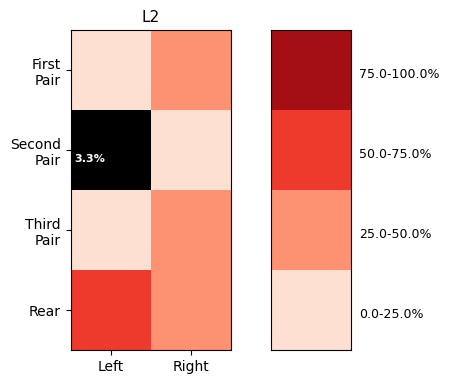

In [7]:
# Functions to make plots

def showSwingCorrelations(ax, leg_to_plot, leg_counts, color_map, num_bins = 1, print_report = False):
    
    cmap = cm.get_cmap(color_map)
    
    # set leg order
    legs = ['L1','R1','L2','R2','L3','R3','L4','R4']
    loc_indices = []
    num_rows = len(legs)/2
    num_cols = len(legs)/num_rows
    for row in np.arange(num_rows):
        for col in np.arange(num_cols):
            loc_indices.append([int(col),-int(row)])
    locs_for_legs = dict(zip(legs, loc_indices))
    
    # convert leg_counts to leg_proportions
    leg_proportions = {}
    for leg in legs:
        leg_proportions[leg] = {}
    
    for ref_leg in legs:
        for other_leg in legs:
            leg_proportions[ref_leg][other_leg] = leg_counts[ref_leg][other_leg] / total_swings[ref_leg]
    
    # get proportion matrix for leg_to_plot
    proportion_matrix = np.array([leg_proportions[leg_to_plot][leg] for leg in legs])
    
    # print out some info if print_report is True
    if print_report:
        print('Proportions for ' + leg_to_plot + ':\n')
        print(proportion_matrix.reshape([4,2]))

    # if num_bins is greater than 1, we will show proportions divided into bins
    # if num_bins is 0 or 1, we will show raw proportions 
    if num_bins <= 1:
        to_show = proportion_matrix
    else:
        proportion_boundaries = np.linspace(0,1,num_bins+1)
        proportion_bins = np.zeros(len(proportion_matrix))
        for i, proportion in enumerate(proportion_matrix):
            for j, bin in enumerate(proportion_boundaries[:-1]):
                if proportion_boundaries[j] < proportion and proportion <= proportion_boundaries[j+1]:
                    proportion_bins[i] = np.mean([proportion_boundaries[j],proportion_boundaries[j+1]])
        to_show = proportion_bins

    # go through to_show and make a rectangle (KLUGEY) of appropriate color    
    for i,leg in enumerate(legs):
        [x,y] = locs_for_legs[leg]        
        rectLowerLeftx = x-0.5
        rectLowerLefty = y-0.5
        if leg == leg_to_plot:
            rect_color = 'k'
        else:
            rect_color = cmap(to_show[i])
        rect = patches.Rectangle((rectLowerLeftx,rectLowerLefty),1,1,facecolor=rect_color)
        ax.add_patch(rect)

    # in box for leg_to_plot, write in the percentage swinging alone
    
    swinging_alone = leg_proportions[leg_to_plot][leg_to_plot]
    perc = str(np.round(swinging_alone * 100,1)) + '%'
    
    [textx, texty] = locs_for_legs[leg_to_plot]
#     print(leg_to_plot, texty, textx) # testing OK
    
    xbuff = 0.45
    ybuff = 0.15
    
    ax.text(textx-xbuff, texty-ybuff, perc, color='w', fontsize=8, fontweight='bold')
    
    if print_report:
        print('boundaries: ', proportion_boundaries)
        print('showing:')
        print(to_show.reshape([4,2]))

    ax.set_title(leg_to_plot, fontsize=axis_fontsize)
    ax.set_yticks(np.arange(-num_rows+1,1))
    ax.set_yticklabels(['Rear','Third\nPair','Second\nPair','First\nPair'])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Left','Right'])
    ax.set_xlim([-0.5,1.5])
    ax.set_ylim([-num_rows+0.5,0.5])
    
    return ax

# homemade legend for these!
def makeLegendForColorBins(ax, num_bins, color_map):

    cmap = cm.get_cmap(color_map)
    proportion_boundaries = np.linspace(0,1,num_bins+1)
    plot_levels = np.zeros(num_bins)
    labels = []
    cols = []
    for i, level in enumerate(proportion_boundaries[:-1]):
        lower_boundary = np.round(proportion_boundaries[i],2)
        upper_boundary = np.round(proportion_boundaries[i+1],2)
        mid_point = np.mean([lower_boundary, upper_boundary])
        plot_levels[i] = mid_point
        labels.append(str(np.round(lower_boundary*100,1)) + '-' + str(np.round(upper_boundary*100,1)) + '%')
        cols.append(cmap(mid_point))
    
    ax.set_ylim([0,num_bins])
    ax.set_xlim([0,1])
    for i, label in enumerate(labels):
        ax.text(1.1, 0.4+i, label, fontsize=tick_fontsize)
        llx = 0
        lly = i
        rect = patches.Rectangle((llx,lly),1,1,facecolor=cols[i])
        ax.add_patch(rect)
    
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

f = plt.figure(figsize=(4,4))
leg_to_plot = 'L2'
num_bins = 4
cmap = 'Reds'
ax1 = f.add_axes([0.1,0.1,0.4,0.8])
ax1 = showSwingCorrelations(ax1, leg_to_plot, leg_counts, cmap, num_bins, True)
ax2 = f.add_axes([0.6, 0.1, 0.2, 0.8])
ax2 = makeLegendForColorBins(ax2, num_bins, cmap)
plt.show()

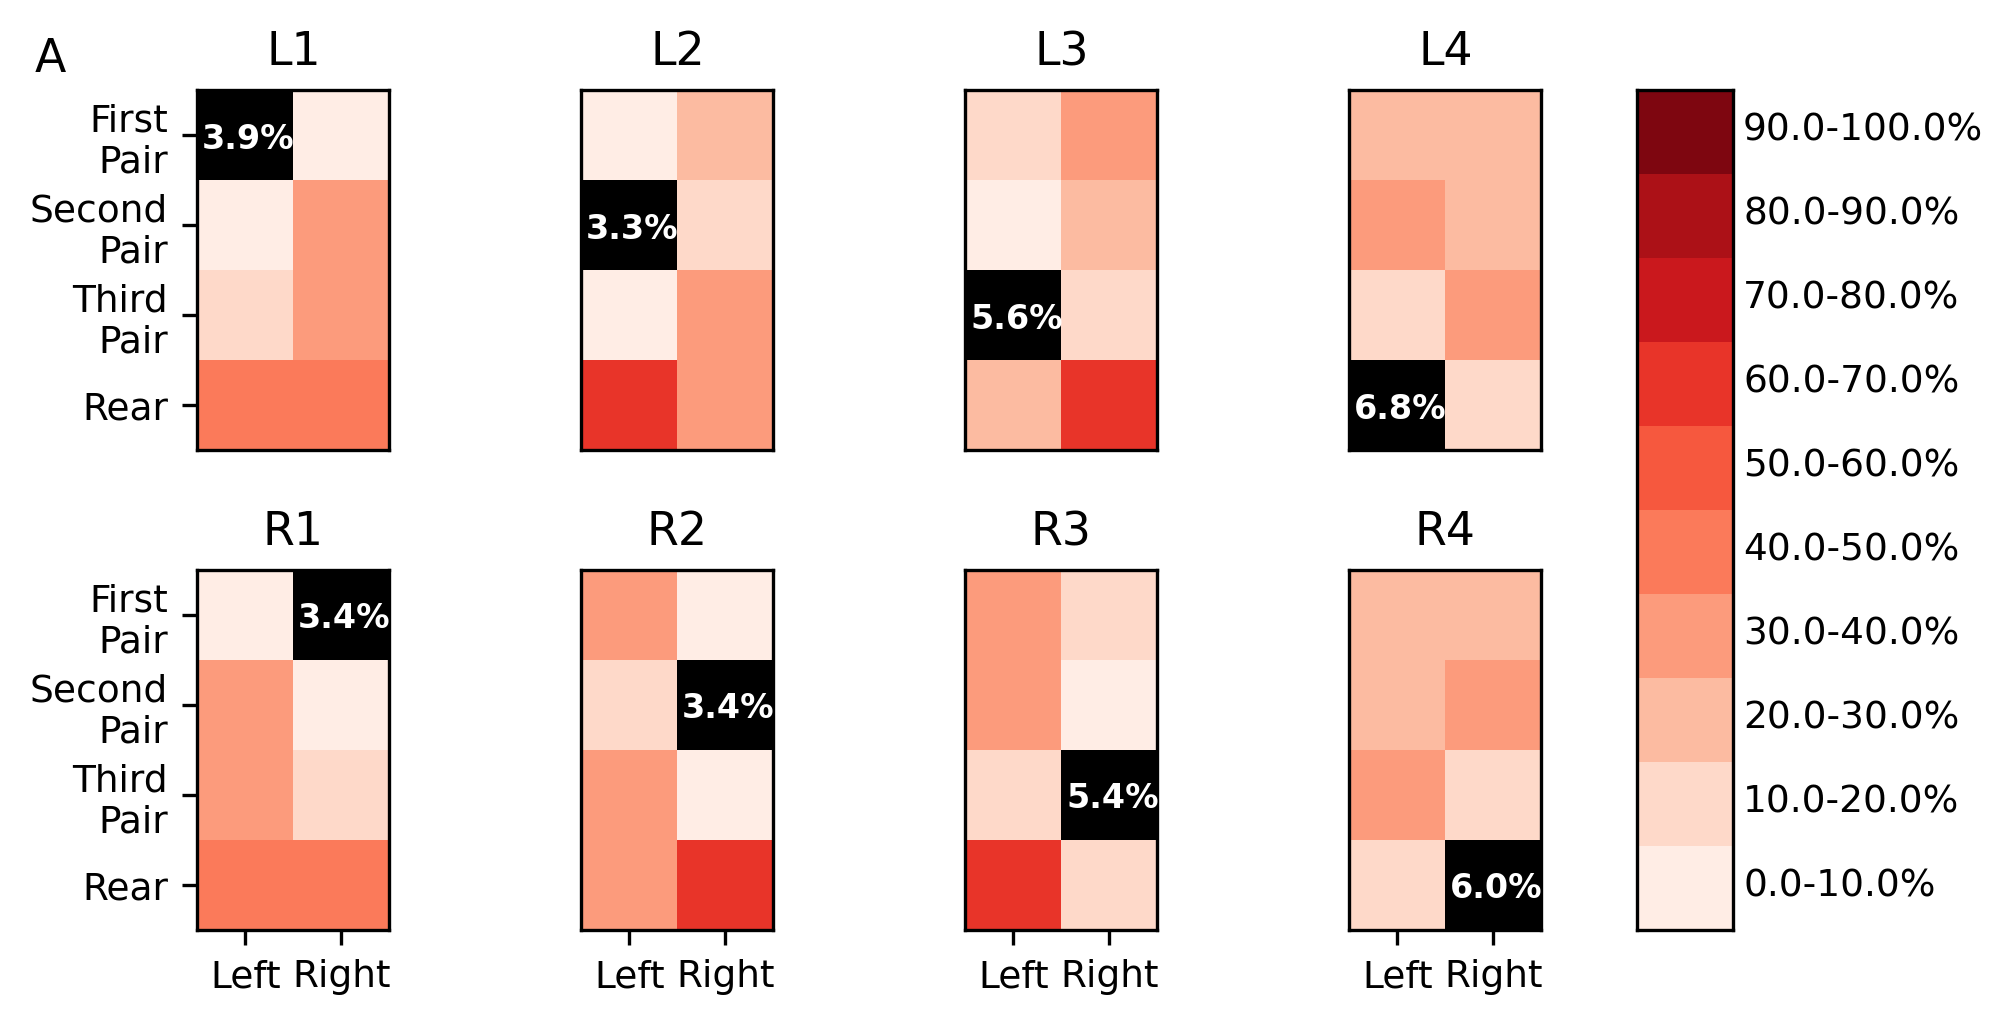

In [8]:
# Show all the legs on a single plot
num_bins = 10 # 4, 5, or 10
cmap = 'Reds'

f = plt.figure(figsize=(8,4), dpi=300)

lefta = [0.1, 0.26, 0.42, 0.58]
bottoma = 0.1
mida = 0.5
a_width = 0.08
a_height = 0.3

a1 = f.add_axes([lefta[0], mida, a_width, a_height])
a2 = f.add_axes([lefta[1], mida, a_width, a_height])
a3 = f.add_axes([lefta[2], mida, a_width, a_height])
a4 = f.add_axes([lefta[3], mida, a_width, a_height])
a5 = f.add_axes([lefta[0], bottoma, a_width, a_height])
a6 = f.add_axes([lefta[1], bottoma, a_width, a_height])
a7 = f.add_axes([lefta[2], bottoma, a_width, a_height])
a8 = f.add_axes([lefta[3], bottoma, a_width, a_height])

leg_order_to_plot = ['L1','L2','L3','L4','R1','R2','R3','R4']
ax_list = [a1,a2,a3,a4,a5,a6,a7,a8]

for i,leg in enumerate(leg_order_to_plot):
    ax_list[i] = showSwingCorrelations(ax_list[i], leg, leg_counts, cmap, num_bins)
    ax_list[i].yaxis.label.set_size(tick_fontsize)
    ax_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize) 
if num_bins > 1:
    if num_bins <= 5:
        a9 = f.add_axes([0.7, mida, 0.04, a_height])
    else:
        a9 = f.add_axes([0.7, 0.1, 0.04, 0.7])
    a9 = makeLegendForColorBins(a9, num_bins, cmap)
    
for ax in [a1,a2,a3,a4]:
    ax.set_xticks([])
    
for ax in [a2,a3,a4,a6,a7,a8]:
    ax.set_yticks([])

a1.annotate('A', xy=(-0.85, 1.05), xycoords='axes fraction', fontsize=axis_fontsize)
    
plt.show()

# Compare timing of REAR swing and stance with other legs

In [9]:
# average swing durations for rear legs
rear_avg_swings = {}
for leg in ['L4','R4']:
    rear_avg_swings[leg] = np.mean(step_df[step_df['legID']==leg].swing.values)
    print(leg,rear_avg_swings[leg])
    
overall_average_swing_rear =  np.mean(step_df[step_df['legID'].isin(['L4','R4'])].swing.values)
print('overall average = ', overall_average_swing_rear)

L4 0.3758415359653867
R4 0.3737205642973413
overall average =  0.3747827735644637


getting data for L4→L3
getting data for R4→R3
  plotting data for pair 3
getting data for L4→L2
getting data for R4→R2
  plotting data for pair 2
getting data for L4→L1
getting data for R4→R1
  plotting data for pair 1


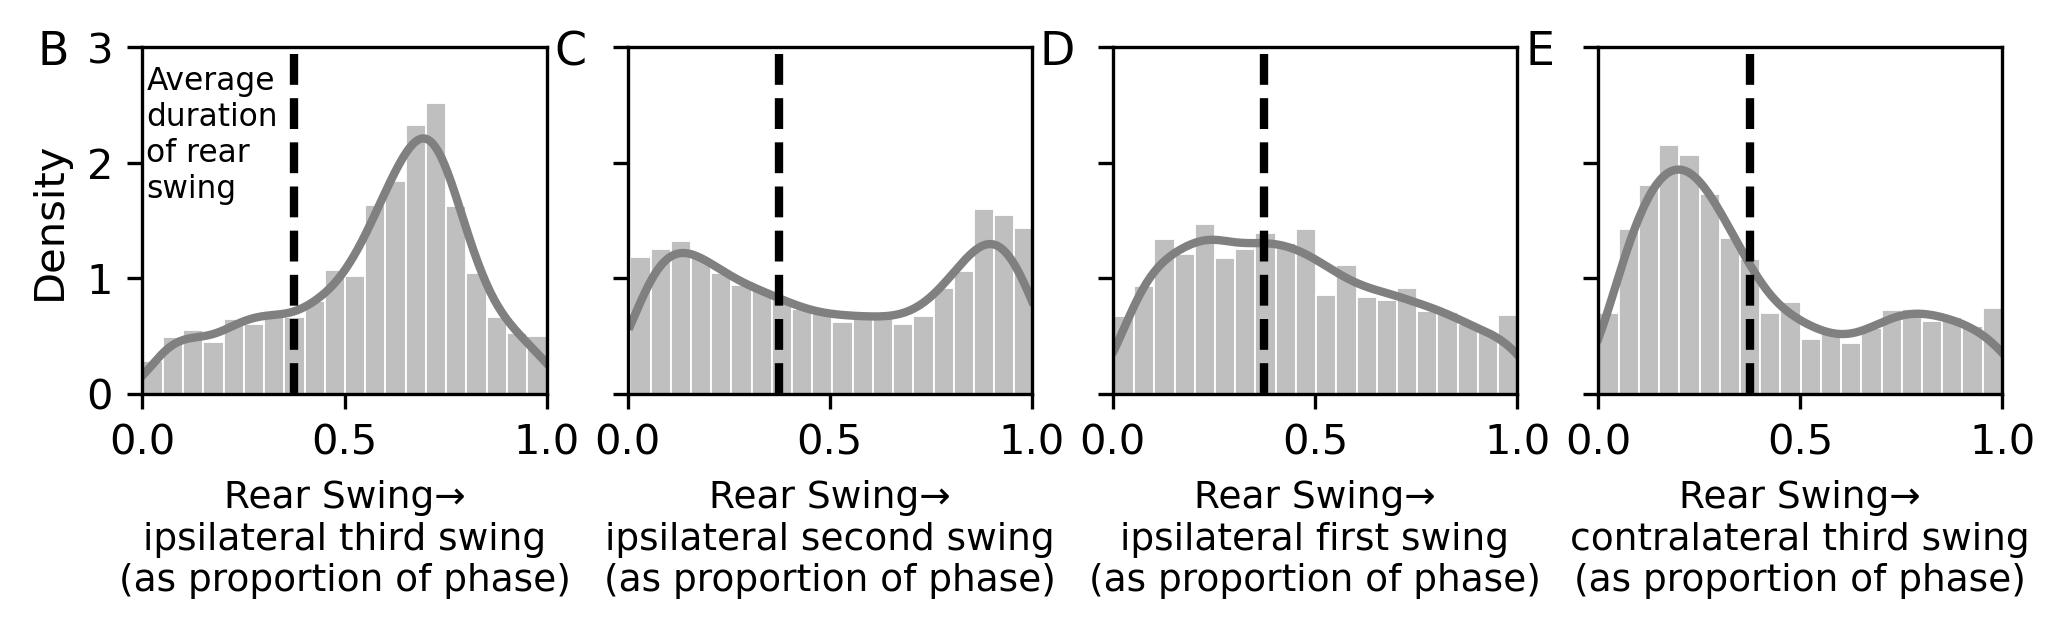

In [10]:
f, [a1,a2,a3,a4] = plt.subplots(1,4, figsize=(8,1.5), dpi = 300, sharey=True)

axes = [a1,a2,a3,a4]

# for all rear legs, get ipsilateral swings for 3rd, 2nd, 1st pair
rear_legs = ['L4','R4']

other_pairs = ['3','2','1']
other_pair_labels = ['third','second','first']

for i, pair in enumerate(other_pairs):
    
    offsets, proportions, speeds = [[],[],[]]

    for leg in rear_legs:
        other_leg = leg[0] + pair
        print('getting data for ' + leg + '→' + other_leg)
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                              step_df, leg, other_leg, 'swingswing')
    
    print('  plotting data for pair ' + pair)
    ax = axes[i]
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color='gray', edgecolor='w', visible=True)
    ax.plot([overall_average_swing_rear, overall_average_swing_rear], [0,4], '--k', linewidth=2)

    ax.set_ylim([0,3])
    ax.set_xlim([0,1])
    ax.set_xlabel('Rear Swing→\nipsilateral ' + other_pair_labels[i] + 
                  ' swing\n(as proportion of phase)', fontsize=tick_fontsize)
    
a1.annotate('B', xy=(-0.26, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)    
a1.text(0.01,1.7,s='Average\nduration\nof rear\nswing',fontsize=tick_fontsize-1.5)

# rear leg vs. contralateral third leg
offsets, proportions, speeds = [[],[],[]]
offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                              step_df, 'R4', 'L3', 'swingswing')
offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                              step_df, 'L4', 'R3', 'swingswing')
a4 = sns.histplot(proportions, ax=a4, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color='gray', edgecolor='w', visible=True)
a4.plot([overall_average_swing_rear, overall_average_swing_rear], [0,4], '--k', linewidth=2)
a4.set_xlabel('Rear Swing→\ncontralateral third swing\n(as proportion of phase)', 
              fontsize=tick_fontsize)
a4.set_xlim([0,1])

letters = ['C','D','E']
for i,ax in enumerate([a2,a3,a4]):
    ax.annotate(letters[i], xy=(-0.18, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)

# plt.tight_layout()
plt.show()

getting data for L4→L3
getting data for R4→R3
  plotting data for pair 3
getting data for L4→L2
getting data for R4→R2
  plotting data for pair 2
getting data for L4→L1
getting data for R4→R1
  plotting data for pair 1


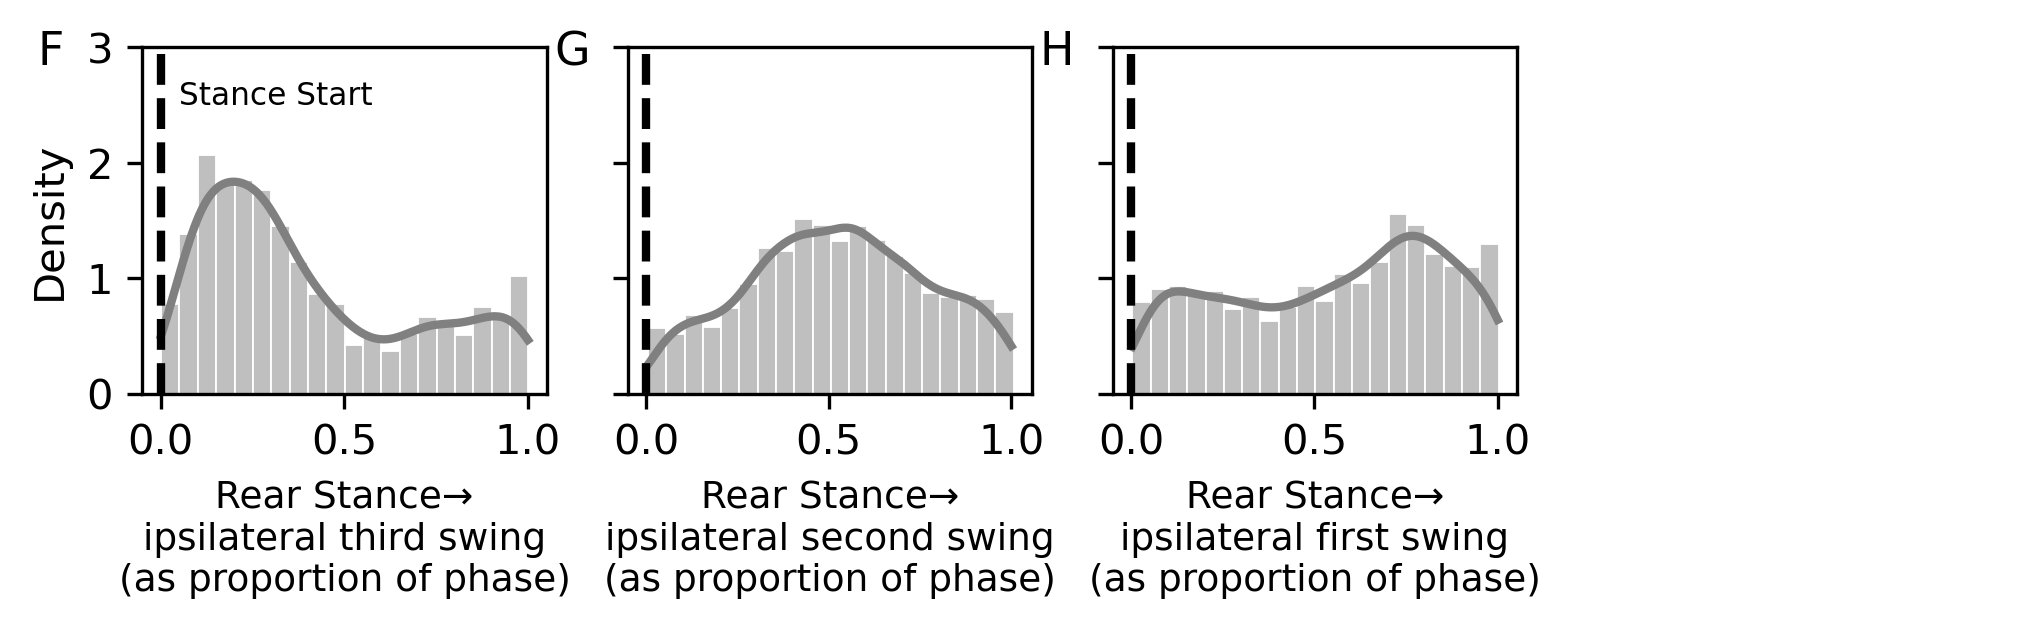

In [11]:
f, [a1,a2,a3,a4] = plt.subplots(1,4, figsize=(8,1.5), dpi = 300, sharey=True)

axes = [a1,a2,a3]

# for all rear legs, get ipsilateral swings for 3rd, 2nd, 1st pair
rear_legs = ['L4','R4']

other_pairs = ['3','2','1']
other_pair_labels = ['third','second','first']

for i, pair in enumerate(other_pairs):
    
    offsets, proportions, speeds = [[],[],[]]

    for leg in rear_legs:
        other_leg = leg[0] + pair
        print('getting data for ' + leg + '→' + other_leg)
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                              step_df, leg, other_leg, 'stanceswing')
    
    print('  plotting data for pair ' + pair)
    ax = axes[i]
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color='gray', edgecolor='w', visible=True)
    ax.plot([0, 0], [0,4], '--k', linewidth=2)

    ax.set_ylim([0,3])
    ax.set_xlabel('Rear Stance→\nipsilateral ' + other_pair_labels[i] + 
                  ' swing\n(as proportion of phase)', fontsize=tick_fontsize)

a1.annotate('F', xy=(-0.26, 0.95), xycoords='axes fraction', fontsize=axis_fontsize) 
letters = ['G','H']
for i,ax in enumerate([a2,a3]):
    ax.annotate(letters[i], xy=(-0.18, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)

a1.text(0.05,2.5,s='Stance Start',fontsize=tick_fontsize-1.5) 
a4.set_axis_off()

# plt.tight_layout()
plt.show()